In [1]:
import torch
import os
from torchvision import datasets, transforms
import torch.nn as nn
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from utils import plot_tsne, tensors_as_images, dataset_first_n, plot_fit
import random
import argparse
import itertools

import IPython.display


import cifar_nets
import training

NUM_CLASSES = 10

In [2]:
def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


In [3]:
args = argparse.Namespace()
args.seed = 0
args.data_path = "/datasets/cv_datasets/data"
args.batch_size = 32
args.latent_dim = 128
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.mnist = False
args.self_supervised = False

In [4]:
freeze_seeds(args.seed)

In [5]:

if args.mnist:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1307], std=[0.3081])  
    ])
    train_dataset = datasets.MNIST(root=args.data_path, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root=args.data_path, train=False, download=True, transform=transform)
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])  
    ])
    train_dataset = datasets.CIFAR10(root=args.data_path, train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root=args.data_path, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


(<Figure size 1000x1000 with 10 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

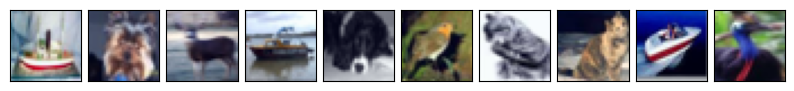

In [6]:

dataset_first_n(train_dataset, 10, figsize=(10,10), nrows=1)

In [7]:


#Data
# When you create your dataloader you should split train_dataset or test_dataset to leave some aside for validation
ds_val, ds_train = torch.utils.data.random_split(train_dataset, [0.2, 0.8])

# ds_train = torch.utils.data.Subset(ds_train, range(100))


dl_train = torch.utils.data.DataLoader(ds_train, batch_size=args.batch_size, shuffle=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=args.batch_size, shuffle=False)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

dl_sample = itertools.cycle(torch.utils.data.DataLoader(ds_train, batch_size=7, shuffle=True))

img_shape = train_dataset[0][0].shape



In [8]:

#Model
model = cifar_nets.AE(img_shape, args.latent_dim).to(args.device)
model_dp = torch.nn.DataParallel(model)

# imgs, _ = next(dl_sample)
# imgs = imgs.to(args.device)
# model.sample(imgs)


#Optimizer
optimizer = torch.optim.Adam(model.parameters())

#Loss
loss_fn = torch.nn.MSELoss()

#Trainer
trainer = training.AETrainer(model_dp, loss_fn, optimizer, args.device)

checkpoint_file = 'checkpoints/cifar_ae'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

In [9]:

model

AE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.01)
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=2048, out_features=128, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=128, out_features=2048, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Unflatten(dim=1, unflattened_

In [10]:
def post_epoch_fn(epoch, train_result, test_result, verbose):
    # Plot some samples if this is a verbose epoch
    if verbose:
        imgs, _ = next(dl_sample)
        imgs = imgs.to(args.device)
        recon_imgs = model.sample(imgs)

        fig, _ = tensors_as_images(list(imgs), figsize=(6,3))
        IPython.display.display(fig)
        plt.close(fig)

        fig, _ = tensors_as_images(list(recon_imgs), figsize=(6,3))
        IPython.display.display(fig)
        plt.close(fig)

--- EPOCH 1/200 ---
test_batch (Avg. Loss 0.037, Accuracy 85.6): 100%|██████████| 313/313 [00:04<00:00, 63.22it/s]
*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 1


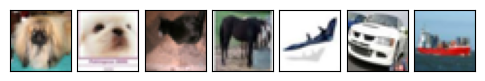

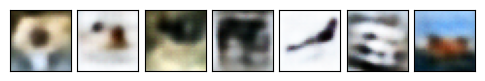

*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 2
*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 3
*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 4
*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 5
--- EPOCH 6/200 ---
test_batch (Avg. Loss 0.021, Accuracy 148.8): 100%|██████████| 313/313 [00:04<00:00, 63.74it/s]
*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 6


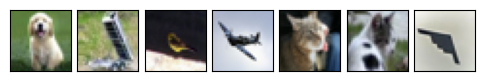

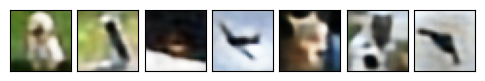

*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 7
*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 8
*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 9
--- EPOCH 11/200 ---
test_batch (Avg. Loss 0.019, Accuracy 163.9): 100%|██████████| 313/313 [00:04<00:00, 67.46it/s]
*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 11


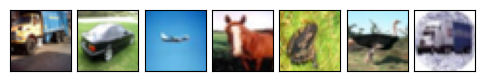

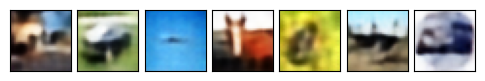

*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 12
*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 13
--- EPOCH 16/200 ---
test_batch (Avg. Loss 0.019, Accuracy 166.0): 100%|██████████| 313/313 [00:06<00:00, 45.85it/s]


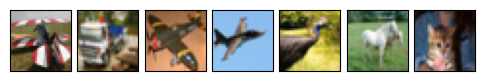

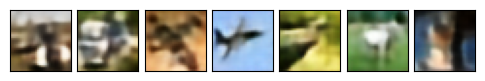

*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 17
--- EPOCH 21/200 ---
test_batch (Avg. Loss 0.019, Accuracy 169.9): 100%|██████████| 313/313 [00:08<00:00, 39.08it/s]
*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 21


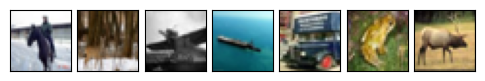

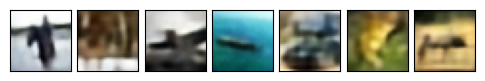

*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 24
--- EPOCH 26/200 ---
test_batch (Avg. Loss 0.018, Accuracy 171.2): 100%|██████████| 313/313 [00:07<00:00, 44.60it/s]
*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 26


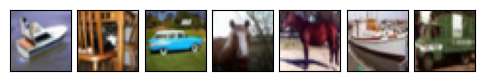

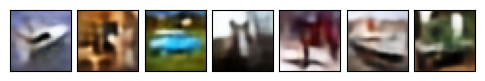

*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 27
*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 30
--- EPOCH 31/200 ---
test_batch (Avg. Loss 0.018, Accuracy 173.1): 100%|██████████| 313/313 [00:05<00:00, 53.66it/s]


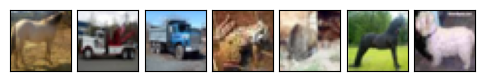

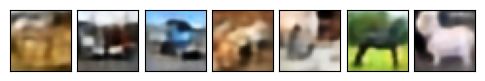

--- EPOCH 36/200 ---
test_batch (Avg. Loss 0.018, Accuracy 172.2): 100%|██████████| 313/313 [00:05<00:00, 54.31it/s]


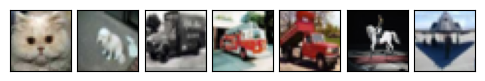

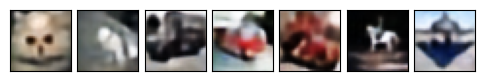

*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 40
--- EPOCH 41/200 ---
test_batch (Avg. Loss 0.018, Accuracy 172.8): 100%|██████████| 313/313 [00:06<00:00, 49.55it/s]


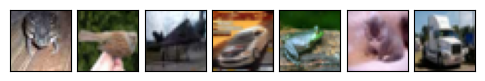

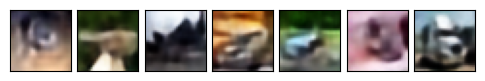

--- EPOCH 46/200 ---
test_batch (Avg. Loss 0.018, Accuracy 172.9): 100%|██████████| 313/313 [00:05<00:00, 59.39it/s]


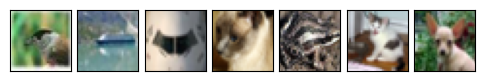

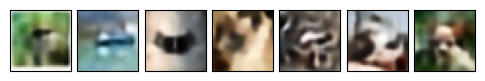

In [ ]:

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    checkpoint_file = checkpoint_file_final
else:
    res = trainer.fit(dl_train, dl_val,
                      num_epochs=100, early_stopping=10, print_every=5,
                      checkpoints=checkpoint_file,
                      post_epoch_fn=post_epoch_fn)


C:\Users\matan\AppData\Local\Temp\ipykernel_13540\3556047334.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state = torch.load(f'{checkpoint_file}.pt', map_locati

*** Images reconstructed from best model:


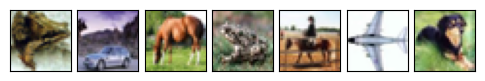

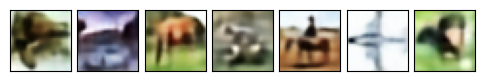

In [12]:

# Plot images from best model
saved_state = torch.load(f'{checkpoint_file}.pt', map_location=args.device)
model_dp.load_state_dict(saved_state['model_state'])

print('*** Images reconstructed from best model:')
imgs, _ = next(dl_sample)
imgs = imgs.to(args.device)
recon_imgs = model.sample(imgs)

fig, _ = tensors_as_images(list(imgs), figsize=(6,3))
IPython.display.display(fig)
plt.close(fig)

fig, _ = tensors_as_images(list(recon_imgs), figsize=(6,3))
IPython.display.display(fig)
plt.close(fig)

In [13]:
# model_dp

# m = torchvision.models.resnet50()
# m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
# m.fc = nn.Linear(m.fc.in_features, args.latent_dim)
# encoder = m



In [14]:
# # Unfreeze only conv1 + layer1 + fc
# for name, param in m.named_parameters():
#     if "conv1" in name or "layer1" in name or "fc" in name:
#         param.requires_grad = True  # Allow training
#     else:
#         param.requires_grad = False  # Keep frozen


In [15]:
encoder = model_dp.module.encoder
for param in encoder.parameters():
    param.requires_grad = False  # Freezes encoder


In [16]:
#Model
classifier = cifar_nets.Classifier(encoder,args.latent_dim, NUM_CLASSES).to(args.device)
# classifier_dp = torch.nn.DataParallel(classifier)

#Optimizer
optimizer = torch.optim.Adam(classifier.parameters())

#Loss
loss_fn = torch.nn.CrossEntropyLoss()

#Trainer
trainer = training.ClassifierTrainer(classifier, loss_fn, optimizer, args.device)

checkpoint_file = 'checkpoints/cifar_classifier'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

--- EPOCH 1/200 ---
test_batch (Avg. Loss 1.603, Accuracy 43.6): 100%|██████████| 313/313 [00:04<00:00, 76.91it/s]
*** Saved checkpoint checkpoints/cifar_classifier.pt at epoch 1
*** Saved checkpoint checkpoints/cifar_classifier.pt at epoch 2
*** Saved checkpoint checkpoints/cifar_classifier.pt at epoch 3
*** Saved checkpoint checkpoints/cifar_classifier.pt at epoch 4
*** Saved checkpoint checkpoints/cifar_classifier.pt at epoch 5
--- EPOCH 6/200 ---
test_batch (Avg. Loss 1.419, Accuracy 49.7): 100%|██████████| 313/313 [00:05<00:00, 62.42it/s]
*** Saved checkpoint checkpoints/cifar_classifier.pt at epoch 6
*** Saved checkpoint checkpoints/cifar_classifier.pt at epoch 7
*** Saved checkpoint checkpoints/cifar_classifier.pt at epoch 8
*** Saved checkpoint checkpoints/cifar_classifier.pt at epoch 9
--- EPOCH 11/200 ---
test_batch (Avg. Loss 1.406, Accuracy 50.6): 100%|██████████| 313/313 [00:03<00:00, 89.60it/s]
*** Saved checkpoint checkpoints/cifar_classifier.pt at epoch 11
*** Saved che

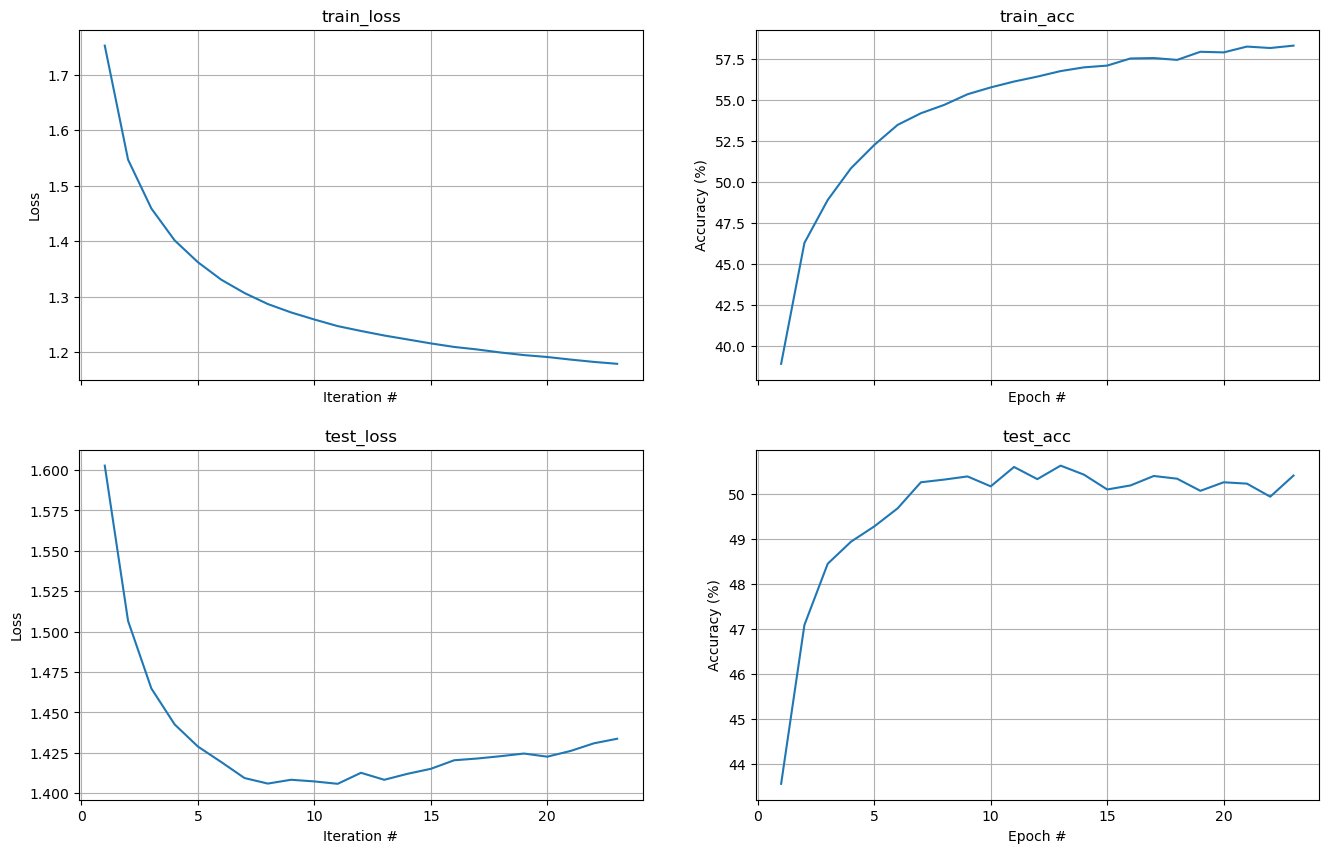

In [ ]:

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    checkpoint_file = checkpoint_file_final
else:
    res = trainer.fit(dl_train, dl_val,
                      num_epochs=100, early_stopping=10, print_every=5,
                      checkpoints=checkpoint_file,)
    plot_fit(res)